In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
import random
import math
from datetime import timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [7]:
hotelstotal = pd.read_csv('../../training_set_VU_DM.csv')

In [9]:
def categorize_date(df):
    
    df['date_time_split'] = pd.to_datetime(df['date_time'])
    df['srch_month'] = df['date_time_split'].dt.month
    df['srch_year'] = df['date_time_split'].dt.year
    df['srch_hour'] = df['date_time_split'].dt.hour

#     bins = [0, 6, 12, 18, 23]
#     labels = [0, 1, 2, 3]
#     df['srch_daytime'] = pd.cut(df['srch_hour'], bins = bins, labels = labels)
    
    df['booking_month'] = (df['date_time_split'] + df['srch_booking_window'].apply(pd.offsets.Day)).dt.month

    df = df.drop(['date_time', 'srch_hour'], axis=1)
    
    return df

def categorize_prop_review_score(df):
    
    df['prop_review_score'] = df['prop_review_score'].fillna(0)
    
    return df
    
def categorize_hist_starrating(df):
    
    df['visitor_hist_starrating'] = df['visitor_hist_starrating'].fillna(-0.5)
    
    bins = [-1, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    df['vis_star'] = pd.cut(df.visitor_hist_starrating, bins, labels = labels)
    
    return df.drop(['visitor_hist_starrating'], axis=1)
#     return df
    
def categorize_hist_usd(df):
    df['vis_usd'] = pd.qcut(df['visitor_hist_adr_usd'], 4, labels = [1, 2, 3, 4])
    
    df['vis_usd'] = df['vis_usd'].cat.add_categories([0])
    df['vis_usd'] = df['vis_usd'].fillna(0)
    
    return df.drop(['visitor_hist_adr_usd'], axis=1)
#     return df
    
def categorize_prop_loc_score(df):
    
    df['prop_location_score1'] = df['prop_location_score1'].round()
    df['prop_location_score2'] = df['prop_location_score2'].fillna(df['prop_location_score2'].mean())
    df['prop_location_score2'] = df['prop_location_score2'].round(1)
    
    return df
    
def categorize_historical_price(df):
    
    df['prop_hist_price'] = pd.qcut(df['prop_log_historical_price'], 6, duplicates = 'drop', labels = [0, 1, 2, 3, 4, 5])
    
#     return df.drop(['prop_log_historical_price'], axis=1)
    return df
    
def categorize_price_usd(df):
    
    q = df['price_usd'].quantile(0.99)
    df['price_usd'] = df[df['price_usd'] < q]
    hotel_id = df.groupby(['prop_id'])
    df['price_usd'] = hotel_id.price_usd.apply(lambda x: x.fillna(x.mean()))
    
    df['cat_price_usd'] = pd.qcut(df['price_usd'], 6, labels = [0, 1, 2, 3, 4, 5])
    df['cat_price_usd'] = df['cat_price_usd'].fillna(5)
    
    return df

def categorize_gross_bookings_usd(df):
    
    df['gross_price_difference'] = df['gross_bookings_usd'] - df['price_usd']
    df['gross_price_difference'] = pd.qcut(df['gross_price_difference'], 4, labels = [1, 2, 3, 4])
    df['gross_price_difference'] = df['gross_price_difference'].cat.add_categories([0])
    df['gross_price_difference'] = df['gross_price_difference'].fillna(0)
    
    return df.drop(['gross_bookings_usd', 'price_usd'], axis=1)
    
def categorize_nights(df):
    
    df['srch_length_of_stay'] = np.where(df['srch_length_of_stay'] > 4, 5, df['srch_length_of_stay'])
    return df
    
def categorize_booking_window(df):
    
    df['srch_booking_window'] = df['srch_booking_window']/7
    df['srch_booking_window'] = df['srch_booking_window'].round(0).astype(int)
    df['srch_booking_window'] = np.where(df['srch_booking_window'] > 12, 12, df['srch_booking_window'])
    
    return df
    
def categorize_srch_count(df):
    
    df['srch_adults_count'] = np.where(df['srch_adults_count'] > 3, 3, df['srch_adults_count'])
    df['srch_children_count'] = np.where(df['srch_children_count'] > 3, 3, df['srch_children_count'])
    df['srch_room_count'] = np.where(df['srch_room_count'] > 2, 2, df['srch_room_count'])
    return df
    
def categorize_log_probs(df):
    
    df['srch_query_affinity_score'] = pd.qcut(df['srch_query_affinity_score'], 4, duplicates = 'drop')
    df['srch_query_affinity_score'] = df['srch_query_affinity_score'].cat.add_categories([0])
    df['srch_query_affinity_score'] = df['srch_query_affinity_score'].fillna(0)
    return df
    
def categorize_distance_hotel(df):
    
    distgroup = df.groupby(["visitor_location_country_id", "prop_country_id"])
    
    df['orig_destination_distance'] = distgroup.orig_destination_distance.apply(lambda x: x.fillna(x.mean()))
    
#     df['orig_destination_distance'] = df['orig_destination_distance'].fillna()
    
    df['orig_destination_distance'] = pd.qcut(df['orig_destination_distance'], 6, labels = [1, 2, 3, 4, 5, 6])
    df['orig_destination_distance'] = df['orig_destination_distance'].cat.add_categories([0])
    df['orig_destination_distance'] = df['orig_destination_distance'].fillna(0)
    return df
    
def categorize_comp_rates(df):
    
    
    df['all_comp_rates'] = df[['comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate','comp8_rate']].min(axis=1)
    df['all_comp_rates'] = df['all_comp_rates'].fillna(2)
    
    df.update(df[['comp1_rate', 'comp2_rate', 'comp3_rate','comp4_rate','comp5_rate','comp6_rate','comp7_rate','comp8_rate']].fillna(0))
    
    df['count_comp_rates'] = df['comp1_rate'] + df['comp2_rate'] + df['comp3_rate'] + df['comp4_rate'] + df['comp5_rate'] + df['comp6_rate'] + df['comp7_rate'] + df['comp8_rate']
    df = df.drop(['comp1_rate', 'comp2_rate', 'comp3_rate','comp4_rate','comp5_rate','comp6_rate','comp7_rate','comp8_rate'], axis=1)
    return df
    
def categorize_comp_inv(df):
    
    df.update(df[['comp1_inv', 'comp2_inv', 'comp3_inv','comp4_inv','comp5_inv','comp6_inv','comp7_inv','comp8_inv']].fillna(0))
    
    df['count_comp_inv'] = df['comp1_inv'] + df['comp2_inv'] + df['comp3_inv'] + df['comp4_inv'] + df['comp5_inv'] + df['comp6_inv'] + df['comp7_inv'] + df['comp8_inv']
    df = df.drop(['comp1_inv', 'comp2_inv', 'comp3_inv','comp4_inv','comp5_inv','comp6_inv','comp7_inv','comp8_inv'], axis=1)
    return df
    
def categorize_comp_perc(df):
    
    df['comps_perc_diff'] = df[['comp1_rate_percent_diff', 'comp2_rate_percent_diff','comp3_rate_percent_diff','comp4_rate_percent_diff','comp5_rate_percent_diff','comp6_rate_percent_diff','comp7_rate_percent_diff','comp8_rate_percent_diff']].mean(axis=1)
    df['comps_perc_diff'] = pd.qcut(df['comps_perc_diff'], 4, labels = [1, 2, 3, 4])
    df['comps_perc_diff'] = df['comps_perc_diff'].cat.add_categories([0])
    df['comps_perc_diff'] = df['comps_perc_diff'].fillna(0)
    df = df.drop(['comp1_rate_percent_diff', 'comp2_rate_percent_diff','comp3_rate_percent_diff','comp4_rate_percent_diff','comp5_rate_percent_diff','comp6_rate_percent_diff','comp7_rate_percent_diff','comp8_rate_percent_diff'], axis=1)
    return df

In [87]:
hotel_id = hotelstotal.groupby("prop_id")["price_usd", "prop_country_id", 
                                                   "prop_starrating", 
#                                                    "prop_review_score",
                                                   "prop_brand_bool", 
#                                                    "prop_location_score2",
                                                   "prop_location_score1",
                                                     "booking_bool"].apply(lambda x: x.mean()).reset_index()

print(hotel_id)

        prop_id    price_usd  prop_country_id  prop_starrating  \
0             1    94.874426            219.0              2.0   
1             2    96.272727            219.0              0.0   
2             3   109.026098            219.0              3.0   
3             4   468.611818            109.0              5.0   
4             5   636.521333             99.0              0.0   
5             6    46.498000            158.0              3.0   
6             7   139.577143             31.0              0.0   
7             8    56.676000            158.0              3.0   
8             9    85.034118            219.0              2.0   
9            10   159.050000             99.0              4.0   
10           11   126.257786            225.0              4.0   
11           12    91.316667             47.0              3.0   
12           13    66.366667            158.0              0.0   
13           14    39.840000            207.0              2.0   
14        

prop_id                 0
price_usd               0
prop_country_id         0
prop_starrating         0
prop_brand_bool         0
prop_location_score1    0
book_probability        0
dtype: int64

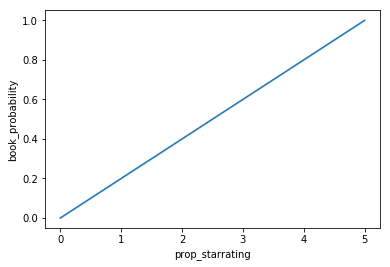

In [82]:
hotel_id["book_probability"] = hotel_id["prop_starrating"].astype(int)/5

sns.lineplot(x = "prop_starrating", y = "book_probability", data = hotel_id)

hotel_id.isna().sum()

In [84]:
class Search:
    def __init__(self, srch_id):
        self.id = id
        self.positive = []
        self.negative = []
        
    def add_positive(self, prop_id):
        self.positive.append(prop_id)
    
    def add_negative(self, prop_id):
        self.negative.append(prop_id)
    
    def get_positive(self):
        return self.positive
    
    def get_negative(self):
        return self.negative

In [91]:
def build_learning_data_from(train_data):
    feature_columns = np.setdiff1d(train_data.columns, np.array(['book_probability']))
    learning_data = train_data.loc[:, feature_columns]
    
    scaler = StandardScaler()
    learning_data.loc[:, ('price_usd')] = scaler.fit_transform(learning_data[['price_usd']])
    learning_data['prop_starrating'] = scaler.fit_transform(learning_data[['prop_starrating']])
    learning_data['prop_country_id'] = scaler.fit_transform(learning_data[['prop_country_id']])
    learning_data['prop_location_score1'] = scaler.fit_transform(learning_data[['prop_location_score1']])
    
    return learning_data

hotel_id = build_learning_data_from(hotel_id)

KeyboardInterrupt: 

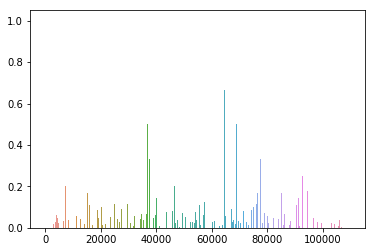

In [93]:
sns.barplot(x = "price_usd", y = "booking_bool", data = hotel_id)